### Load Google News Word Vectors

In [55]:
from gensim.models import Word2Vec

model = Word2Vec.load_word2vec_format('/Users/ebanner/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

model

### Load Some Words

In [62]:
words = pd.Series.from_csv('words.csv', index_col=None)

words

0        jellyfish
1       cloistered
2            shade
3           decide
4           juggle
5             tiny
6             pies
7             used
8             duck
9             rock
10         jobless
11           offer
12           salty
13        governor
14            gray
15           occur
16          acidic
17          abrupt
18           steer
19        increase
20          wooden
21        decorous
22            loud
23         prepare
24            knee
25            fail
26          petite
27        birthday
28          cuddly
29            wash
          ...     
970           fuel
971          story
972          reach
973       discover
974         loving
975     acceptable
976         cherry
977           grab
978         harass
979            ten
980       complete
981         caring
982          eight
983     thundering
984         arrive
985          screw
986       chemical
987        shallow
988      marvelous
989         eggnog
990        curtain
991         

### Lookup Words from Pretrained Emebddings

Only use words which have an embedding though!

In [63]:
iv_words = np.array([word for word in words if word in model])
W = np.array([model[word] for word in iv_words], dtype='float64')

W.shape

(997, 300)

### Reduce Embedding to 2D

In [64]:
from tsne import bh_sne

W_2d = bh_sne(W)

W_2d.shape

(997, 2)

### Sample 20 Random Words

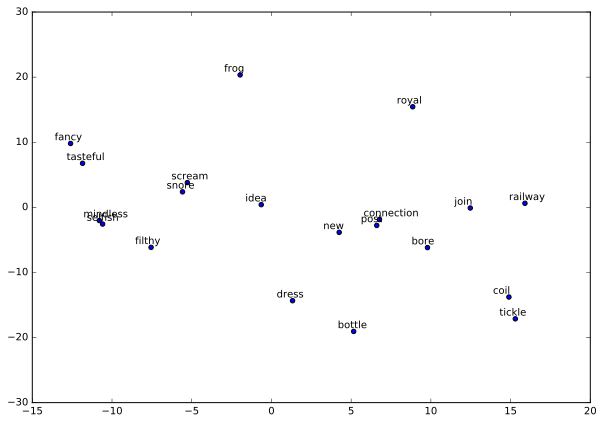

In [69]:
idxs = np.random.choice(len(W_2d), replace=False, size=20)

fig, axes = plt.subplots(figsize=[10, 7])
axes.scatter(x=W_2d[idxs, 0], y=W_2d[idxs, 1])

for w, word in zip(W_2d[idxs], iv_words[idxs]):
    axes.annotate(word, [w[0]-1, w[1]+.5])

### Define Corpora

In [1]:
corpora = ['I really love this movie .',
           'I really hate this movie .'
]

### Vectorize Corpora

In [2]:
from vectorizer import Vectorizer

vectorizer = Vectorizer() 
vectorizer.fit(corpora, maxlen=6)
X = vectorizer.texts_to_sequences(corpora)

from keras.utils.np_utils import to_categorical

y = to_categorical([1, 0])

X, y

Using Theano backend.


(array([[1, 5, 6, 4, 2, 3],
        [1, 5, 7, 4, 2, 3]], dtype=int32), array([[ 0.,  1.],
        [ 1.,  0.]]))

### Define Keras Model

The model:

- Look up the words in the embedding table
- Average them
- Run them through a linear layer
- Appy softmax

In [3]:
from keras.layers import Input, Embedding, Dense, Flatten
from keras.layers.convolutional import AveragePooling1D
from keras.models import Model

max_doclen = X.shape[1]
word_dim, vocab_size = 2, np.max(X)+1

input = Input(shape=[max_doclen], dtype='int32')
embedded = Embedding(output_dim=word_dim, input_dim=vocab_size, input_length=max_doclen, name='embedding')(input)
averaged = AveragePooling1D(pool_length=vocab_size-2)(embedded)
averaged = Flatten()(averaged)
probas = Dense(output_dim=2, activation='softmax')(averaged)

model = Model(input=input, output=probas)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6)             0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 6, 2)          16          input_1[0][0]                    
____________________________________________________________________________________________________
averagepooling1d_1 (AveragePoolin(None, 1, 2)          0           embedding[0][0]                  
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 2)             0           averagepooling1d_1[0][0]         
___________________________________________________________________________________________

### Visualize Model

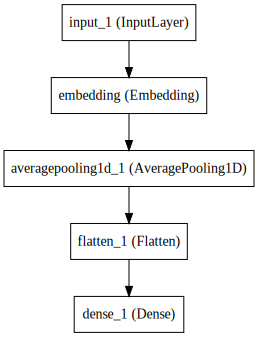

In [4]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train Model on Batch and Plot Embeddings

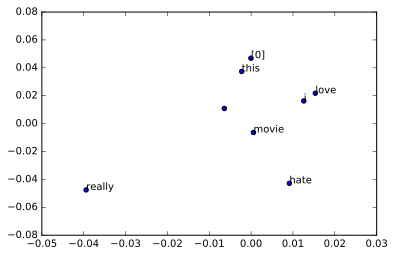

In [5]:
model.train_on_batch(X, y)

E = model.get_layer('embedding').W.eval()

fig, axes = plt.subplots()
axes.scatter(x=E[:, 0], y=E[:, 1])

for e, (idx, word) in zip(E, sorted(vectorizer.idx2word.items())):
    axes.annotate(word, [e[0], e[1]])